In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
%matplotlib inline
from scipy import stats

In [2]:
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("The configuration file was not found!")
    

In [3]:
filename = config['data']['clean']['clean_1']
df_all = pd.read_csv(filename)

In [4]:
df_all = df_all.drop_duplicates(subset='visit_id')  ## unique visit ids
df_all['Completed'].value_counts()

Completed
False    81097
True     74866
Name: count, dtype: int64

In [5]:
relative_path = config['data']['clean']['clean_2']
df_all.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

In [6]:
df_filtered = df_all[df_all['Completion Time'].notnull()]  # only the estimated completion time

In [7]:
# Convert columns to numeric
columns_to_convert = [
    'Completion Time', 'Step 1 Time', 'Step 2 Time', 
    'Step 3 Time', 'Confirm Time', 'clnt_tenure_yr', 
    'clnt_tenure_mnth', 'clnt_age', 'num_accts', 
    'bal', 'calls_6_mnth', 'logons_6_mnth'
]

df_filtered[columns_to_convert] = df_filtered[columns_to_convert].apply(pd.to_numeric, errors='coerce')

C:\Users\salto\AppData\Local\Temp\ipykernel_4388\3757444700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[columns_to_convert] = df_filtered[columns_to_convert].apply(pd.to_numeric, errors='coerce')


# Remove outliers

In [8]:
df = df_filtered.copy()

In [9]:
df

,Unnamed: 0,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,...,visit_id,process_step,date_time,Completed,Completion Time,Step 1 Time,Step 2 Time,Step 3 Time,Confirm Time,has_error
0,0,169,Random,21.0,262.0,47.5,M,2.0,501570.72,4.0,...,749567106_99161211863_557568,confirm,2017-04-12 20:23:09,True,213.0,9.0,46.0,94.0,64.0,False
7,7,546,Random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,731811517_9330176838_94847,confirm,2017-06-17 10:05:42,True,133.0,10.0,13.0,87.0,23.0,False
12,12,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,...,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,True,158.0,7.0,32.0,99.0,20.0,False
17,17,647,Test,12.0,151.0,57.5,M,2.0,30525.80,0.0,...,40369564_40101682850_311847,confirm,2017-04-12 15:47:45,True,377.0,7.0,18.0,189.0,163.0,False
22,22,722,Random,11.0,143.0,59.5,F,2.0,22466.17,1.0,...,984487154_55831795985_521110,confirm,2017-04-19 15:00:09,True,233.0,2.0,19.0,50.0,162.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736739,736739,9999451,Random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611106889_67993488256_946460,confirm,2017-06-07 16:13:32,True,168.0,9.0,15.0,83.0,61.0,False
736754,736754,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,6.0,...,870243567_56915814033_814203,confirm,2017-05-08 16:09:40,True,75.0,5.0,10.0,39.0,21.0,False
736759,736759,9999768,Random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85676722_11636430786_122704,confirm,2017-06-03 18:13:16,True,112.0,3.0,12.0,64.0,33.0,True
736773,736773,9999839,Random,13.0,160.0,28.5,F,2.0,67425.35,3.0,...,715530422_68620416793_515645,confirm,2017-03-29 12:13:03,True,91.0,3.0,15.0,38.0,35.0,False


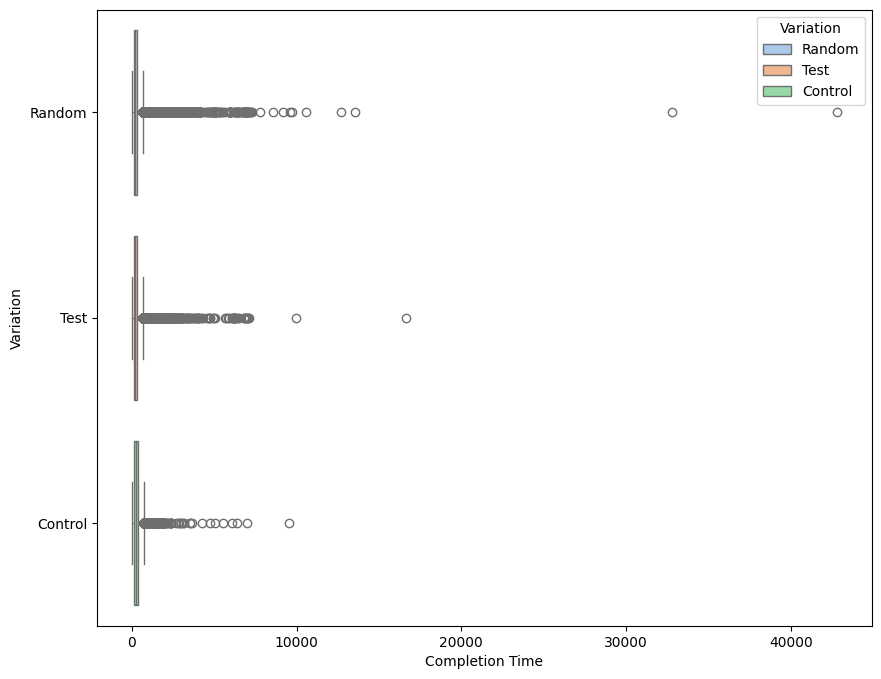

In [10]:
plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Completion Time', y='Variation', hue='Variation', palette = 'pastel', legend = True)
plt.show()

In [11]:
def tukeys_test_outliers(data, repl_type,k=1):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    sigma = data.std()
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    from scipy.stats import median_abs_deviation
    mad_score = median_abs_deviation(data)
    print(mad_score)
    
    # Replace or discard outliers
    if repl_type == 'median':
        data = pd.Series(np.where(np.logical_or(data < lower_bound, data > upper_bound), median_val, data), index=data.index)
    elif repl_type == 'Tukey':
        data = pd.Series(np.where(data < lower_bound, lower_bound, np.where(data > upper_bound, upper_bound, data)), index=data.index)
    elif repl_type == 'Nat_IQR':
        data = pd.Series(np.where(np.logical_or(data < k*lower_bound, data > k*upper_bound), np.nan, data), index=data.index)
    elif repl_type == 'Nat_sigma':
        data = pd.Series(np.where(np.logical_or(data < -3*sigma, data > 3*sigma), np.nan, data), index=data.index)
    elif repl_type == 'Nat_mad':
        data = pd.Series(np.where(np.logical_or(data < -4*mad_score, data > 4*mad_score), np.nan, data), index=data.index)
        
    
    return data

In [12]:
# Apply the outlier removal function to each group with different k
def apply_outlier_removal(group):
    k_values = {'Control': 1, 'Random': 1, 'Test': 1}  # Define k values for each group
    
    # Get the k value for the current group
    k = k_values.get(group['Variation'].iloc[0], 1)  
    
    # Apply outlier removal function with the selected k value
    group['Completion Time'] = tukeys_test_outliers(group['Completion Time'], repl_type='Nat_sigma', k=k)
    return group

# Apply the outlier removal function to each group
df_outliers = df.groupby('Variation').apply(apply_outlier_removal).reset_index(drop=True)

102.0
89.0
89.0


C:\Users\salto\AppData\Local\Temp\ipykernel_4388\1933479217.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_outliers = df.groupby('Variation').apply(apply_outlier_removal).reset_index(drop=True)


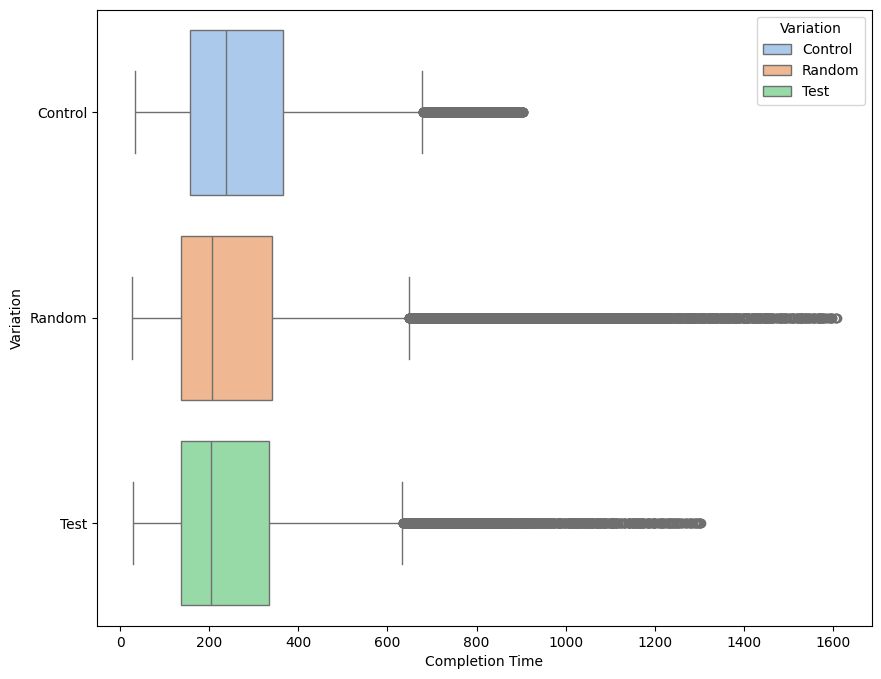

In [13]:
plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_outliers, x='Completion Time', y='Variation', hue='Variation', palette = 'pastel', legend = True)
#plt.savefig('../images/outliers_applied_tukey.png')
plt.show()

In [14]:
df_outliers.dropna(subset= 'Completion Time', inplace=True)
mean_outliers_filtered = df_outliers.groupby('Variation')['Completion Time'].mean()
mean_outliers_filtered

Variation
Control    285.957024
Random     286.040203
Test       275.568424
Name: Completion Time, dtype: float64

In [15]:
relative_path = config['data']['clean']['clean_3']
df_outliers.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

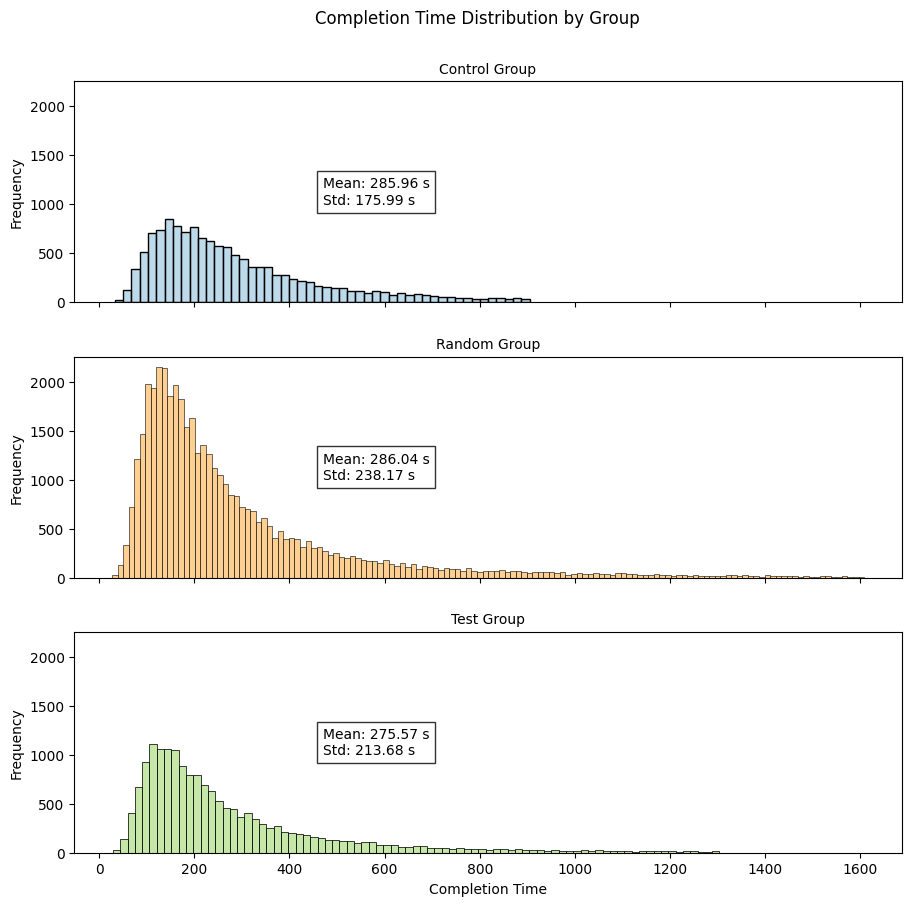

In [16]:
# Calculate mean and std for each group
group_stats = df_outliers.groupby('Variation')['Completion Time'].agg(['mean', 'std']).reset_index()
palette = {"Control": "#a6cee3", "Random": "#fdbf6f", "Test": "#b2df8a"}

# Create the FacetGrid with larger figures and custom palette
g = sns.FacetGrid(df_outliers, col="Variation", col_wrap=1, height=3, aspect=3, sharex=True, sharey=True)

# Function to annotate each plot with mean and std
def annotate(data, ax, **kws):
    variation = data['Variation'].iloc[0]
    stats = group_stats[group_stats['Variation'] == variation]
    mean = stats['mean'].values[0]
    std = stats['std'].values[0]
    ax.text(0.3, 0.5, f'Mean: {mean:.2f} s\nStd: {std:.2f} s', 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='center',
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.8))

# Apply the histplot and annotation to each subplot individually
for ax, variation in zip(g.axes.flatten(), palette.keys()):
    subset = df_outliers[df_outliers['Variation'] == variation]
    sns.histplot(subset['Completion Time'], ax=ax, color=palette[variation])
    annotate(subset, ax=ax)
    # Add right and top axes
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

# Add titles and labels
g.set_axis_labels("Completion Time", "Frequency")
g.set_titles(col_template="{col_name} Group")

# Add a main title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Completion Time Distribution by Group', fontsize=12)

# Show the plot
plt.show()

# Random group of users

## Check Statistically difference in Means

In [17]:
test_times = df_outliers[df_outliers['Variation'] == 'Test']['Completion Time']
random_times = df_outliers[df_outliers['Variation'] == 'Random']['Completion Time']
control_times = df_outliers[df_outliers['Variation'] == 'Control']['Completion Time']

In [18]:
from scipy.stats import ttest_ind

# Welch's t-test
_, p_welch_test_random = ttest_ind(test_times, random_times, equal_var=False)
print("P-value for Welch's t-test between test and random groups:", p_welch_test_random)

_, p_welch_control_random = ttest_ind(control_times, random_times, equal_var=False)
print("P-value for Welch's t-test between control and random groups:", p_welch_control_random)

P-value for Welch's t-test between test and random groups: 1.707696449297244e-07
P-value for Welch's t-test between control and random groups: 0.9652390163390285


## Check Homogeneity of Variances

In [19]:
from scipy.stats import levene

# Levene's Test for equality of variances
_, p_levene = levene(test_times, random_times)
print("P-value for Levene's test between test and random groups:", p_levene)

_, p_levene = levene(control_times, random_times)
print("P-value for Levene's test between control and random groups:", p_levene)



P-value for Levene's test between test and random groups: 1.257144565245671e-07
P-value for Levene's test between control and random groups: 5.412035873450838e-26


* For the test group versus the random group, there is a significant difference in mean completion times, indicating that the completion times for the test group are likely different from those in the random group.
* For the control group versus the random group, there is no significant difference in mean completion times, suggesting that the completion times for the control group may be similar to those in the random group.
* Levene's test indicates unequal variances between the control and random groups, which could impact the interpretation of the t-test results.

Considering these findings, it seems reasonable to exclude the random group from further analysis, as it may introduce noise or bias due to the significant differences observed in completion times and variances compared to the test and control groups.

# Data Insights

## KPI: Completion Rate

In [20]:
# total numbers of visits that entered the process
n_test = len(df_all[df_all['Variation'] =='Test']['Completed'])
n_control = len(df_all[df_all['Variation'] =='Control']['Completed'])
n_control, n_test

(31236, 36619)

In [21]:
# total numbers of visits that completed the process
n_test_completed = len(df_all[(df_all['Variation'] == 'Test') & (df_all['Completed'] == True)])
n_control_completed = len(df_all[(df_all['Variation'] == 'Control') & (df_all['Completed'] == True)])
n_control_completed, n_test_completed

(13896, 17364)

In [22]:
completion_rate_test = n_test_completed/n_test
completion_rate_control = n_control_completed/n_control

print (f"Completion rates of the control group: {completion_rate_control*100:.2f} %")
print (f"Completion rates of the test group: {completion_rate_test*100:.2f} %")

Completion rates of the control group: 44.49 %
Completion rates of the test group: 47.42 %


In [23]:
# Chi-Square Test
contingency_table = [[n_control_completed, n_control - n_control_completed],
                     [n_test_completed, n_test - n_test_completed]]

chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Print Statistical Test Results
print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-Value: {p_value}")

Chi-Square Test Statistic: 58.163250921572235
P-Value: 2.4124374670838854e-14


In [24]:
data = { "Variation": ["Control", "Test"], 
         "Completion Rate": [completion_rate_control, completion_rate_test ],
         "P-value": [p_value, p_value ]}

# Create the DataFrame
kpi_1 = pd.DataFrame(data)

relative_path = config['data']['clean']['clean_4']
kpi_1.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

The new UI with in-context prompts improves the completion rate of the process. The new UI have substantially increased the number of users who completed the process.

## KPI: Completion Times

In [25]:
df2 = df_outliers[df_outliers['Variation'].isin(['Control', 'Test'])]

In [26]:
df2.isna().sum()

Unnamed: 0           0
client_id            0
Variation            0
clnt_tenure_yr       9
clnt_tenure_mnth     9
clnt_age            10
gendr                9
num_accts            9
bal                  9
calls_6_mnth         9
logons_6_mnth        9
index                0
visitor_id           0
visit_id             0
process_step         0
date_time            0
Completed            0
Completion Time      0
Step 1 Time          0
Step 2 Time          0
Step 3 Time          0
Confirm Time         0
has_error            0
dtype: int64

In [27]:
df2.dropna(subset=['clnt_tenure_mnth', 'clnt_age', 'bal', 'has_error'], inplace=True)

C:\Users\salto\AppData\Local\Temp\ipykernel_4388\1611459161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset=['clnt_tenure_mnth', 'clnt_age', 'bal', 'has_error'], inplace=True)


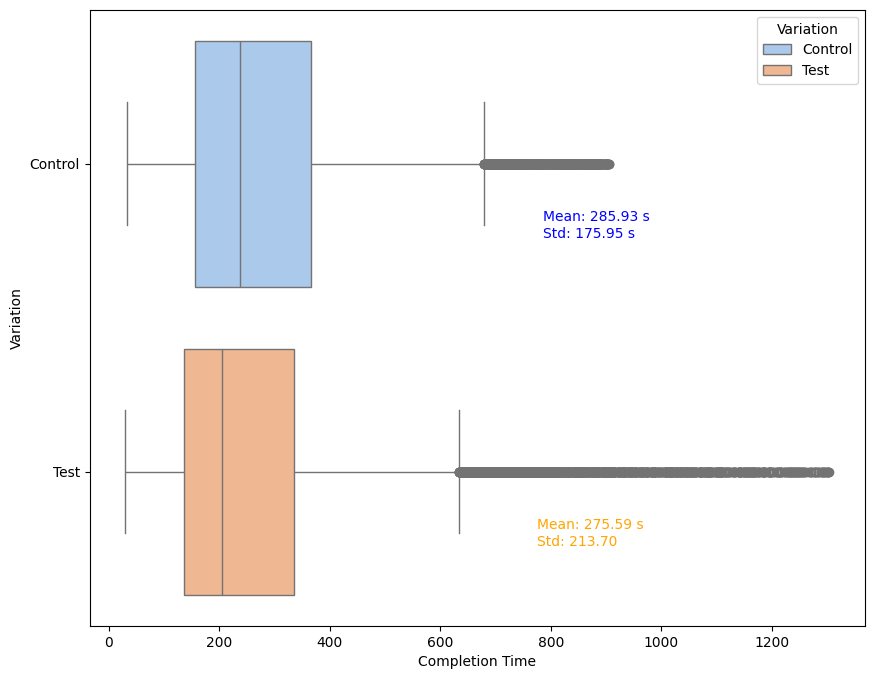

In [28]:
avg_control = df2[df2['Variation']=='Control']['Completion Time'].mean()
std_control = df2[df2['Variation']=='Control']['Completion Time'].std()

avg_test = df2[df2['Variation']=='Test']['Completion Time'].mean()
std_test = df2[df2['Variation']=='Test']['Completion Time'].std()

plt.subplots(figsize=(10, 8))
ax = sns.boxplot(data=df2, x='Completion Time', y='Variation', hue='Variation', palette='pastel', legend=True)

# Annotate mean and std for Control
ax.text(avg_control + 500, 0.2, f'Mean: {avg_control:.2f} s\nStd: {std_control:.2f} s', color='blue', fontsize=10, ha='left', va='center')

# Annotate mean and std for Test
ax.text(avg_test + 500, 1.2, f'Mean: {avg_test:.2f} s\nStd: {std_test:.2f} ', color='orange', fontsize=10, ha='left', va='center')

plt.show()

In [29]:
print('Average completion time of the test group:', avg_test)
print('Average completion time of the control group:', avg_control)

Average completion time of the test group: 275.5946375957572
Average completion time of the control group: 285.93404861944776


In [30]:
# Welch's t-test
_, p_welch_test_control = ttest_ind(test_times, control_times, equal_var=False)
print("P-value for Welch's t-test between test and control groups:", p_welch_test_control)

P-value for Welch's t-test between test and control groups: 3.49918181436541e-06


In [31]:
data = { "Variation": ["Control", "Test"], 
         "Completion Time": [avg_control, avg_test ],
         "P-value": [p_welch_test_control, p_welch_test_control]}

# Create the DataFrame
kpi_2 = pd.DataFrame(data)

relative_path = config['data']['clean']['clean_5']
kpi_2.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

There is statistically significant difference in mean completion times between the test group (using the new UI with prompts) and the control group (using the traditional UI). This result supports the hypothesis that the changes introduced in the new UI, along with the prompts, have influenced user behavior. It indicates that the new UI has likely contributed to different completion rates compared to the traditional UI. In conclusion, based on this analysis, Vanguard can consider adopting the new UI, as it appears to lead to significantly different completion rates compared to the traditional UI.

## KPI Step-by-Step Times

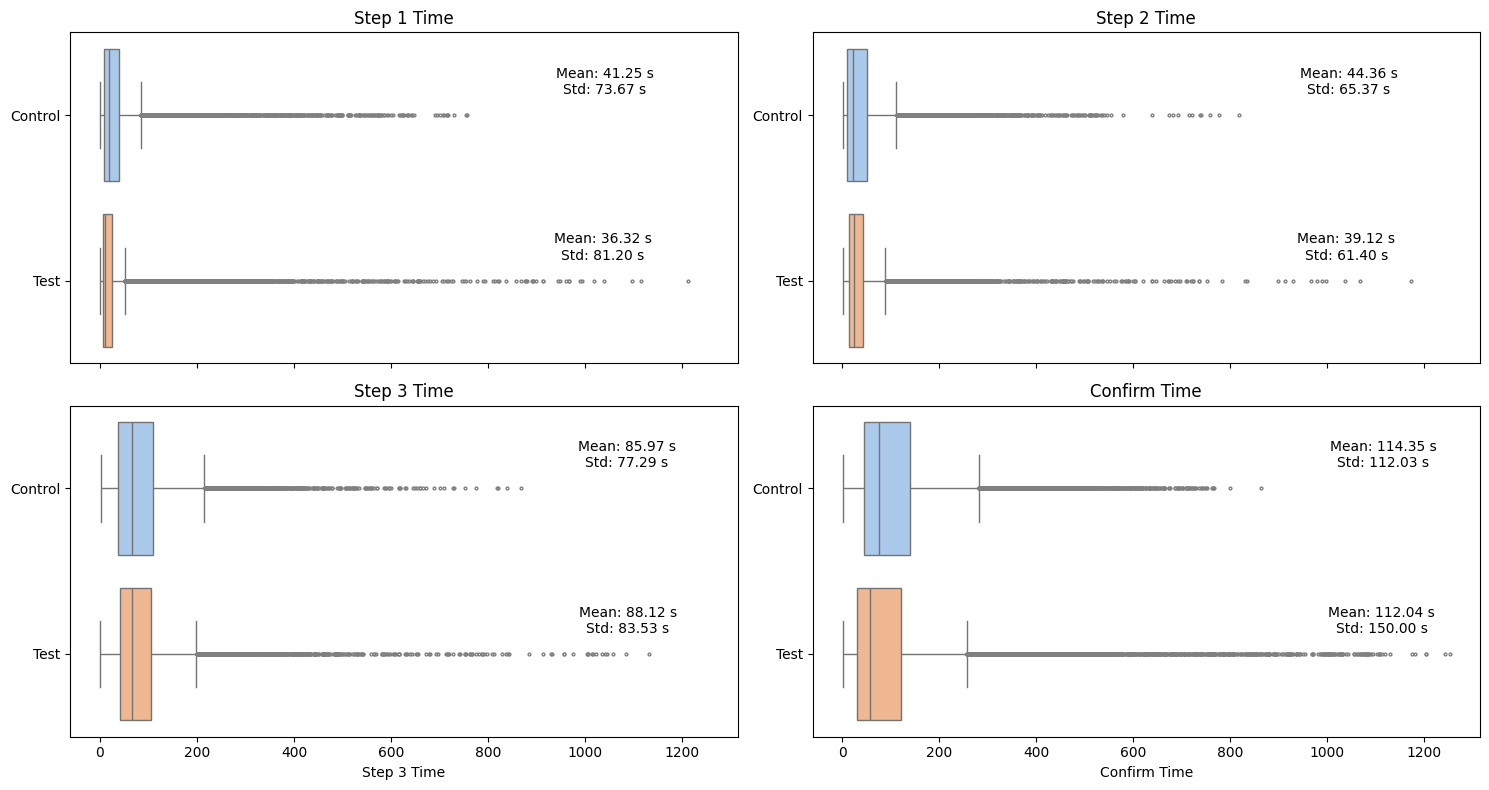

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

# Calculate mean and standard deviation for each component in each subplot
mean_vals_1 = df2.groupby('Variation')['Step 1 Time'].mean()
std_vals_1 = df2.groupby('Variation')['Step 1 Time'].std()

mean_vals_2 = df2.groupby('Variation')['Step 2 Time'].mean()
std_vals_2 = df2.groupby('Variation')['Step 2 Time'].std()

mean_vals_3 = df2.groupby('Variation')['Step 3 Time'].mean()
std_vals_3 = df2.groupby('Variation')['Step 3 Time'].std()

mean_vals_confirm = df2.groupby('Variation')['Confirm Time'].mean()
std_vals_confirm = df2.groupby('Variation')['Confirm Time'].std()

# Boxplot for Step 1 Time
sns.boxplot(data=df2, x='Step 1 Time', y='Variation', hue='Variation', palette = 'pastel', ax=axes[0, 0],
            flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='grey', markersize=2, linestyle='none'))
axes[0, 0].set_title('Step 1 Time')
axes[0, 0].set_ylabel('')

# Annotate mean and std for Step 1 Time
for i, (mean_val, std_val) in enumerate(zip(mean_vals_1, std_vals_1)):
    axes[0, 0].text(mean_val+1000, i-0.2, f'Mean: {mean_val:.2f} s\nStd: {std_val:.2f} s', fontsize=10, ha='center', va='center')

# Boxplot for Step 2 Time
sns.boxplot(data=df2, x='Step 2 Time', y='Variation', hue='Variation', palette = 'pastel', ax=axes[0, 1],
            flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='grey', markersize=2, linestyle='none'))
axes[0, 1].set_title('Step 2 Time')
axes[0, 1].set_ylabel('')

# Annotate mean and std for Step 2 Time
for i, (mean_val, std_val) in enumerate(zip(mean_vals_2, std_vals_2)):
    axes[0, 1].text(mean_val+1000, i-0.2, f'Mean: {mean_val:.2f} s\nStd: {std_val:.2f} s', fontsize=10, ha='center', va='center')

# Boxplot for Step 3 Time
sns.boxplot(data=df2, x='Step 3 Time', y='Variation', hue='Variation', palette = 'pastel', ax=axes[1, 0],
            flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='grey', markersize=2, linestyle='none'))
axes[1, 0].set_title('Step 3 Time')
axes[1, 0].set_ylabel('')

# Annotate mean and std for Step 3 Time
for i, (mean_val, std_val) in enumerate(zip(mean_vals_3, std_vals_3)):
    axes[1, 0].text(mean_val+1000, i-0.2, f'Mean: {mean_val:.2f} s\nStd: {std_val:.2f} s', fontsize=10, ha='center', va='center')

# Boxplot for Confirm Time
sns.boxplot(data=df2, x='Confirm Time', y='Variation', hue='Variation', palette = 'pastel', ax=axes[1, 1],
            flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='grey', markersize=2, linestyle='none'))
axes[1, 1].set_title('Confirm Time')
axes[1, 1].set_ylabel('')

# Annotate mean and std for Confirm Time
for i, (mean_val, std_val) in enumerate(zip(mean_vals_confirm, std_vals_confirm)):
    axes[1, 1].text(mean_val+1000, i-0.2, f'Mean: {mean_val:.2f} s\nStd: {std_val:.2f} s', fontsize=10, ha='center', va='center')

plt.tight_layout()
plt.show()

In [33]:
print('Average completion time of Step 1 of the test group:', mean_vals_1[1])
print('Average completion time of Step 1 of the control group:', mean_vals_1[0])
print()
print('Average completion time of Step 2 of the test group:', mean_vals_2[1])
print('Average completion time of Step 2 of the control group:', mean_vals_2[0])
print()
print('Average completion time of Step 3 of the test group:', mean_vals_3[1])
print('Average completion time of Step 3 of the control group:', mean_vals_3[0])
print()
print('Average completion time of Confirm Step of the test group:', mean_vals_confirm[1])
print('Average completion time of Confirm Step of the control group:', mean_vals_confirm[0])

Average completion time of Step 1 of the test group: 36.315262227460224
Average completion time of Step 1 of the control group: 41.25285114045618

Average completion time of Step 2 of the test group: 39.12280494991161
Average completion time of Step 2 of the control group: 44.35526710684274

Average completion time of Step 3 of the test group: 88.11897466116676
Average completion time of Step 3 of the control group: 85.97103841536615

Average completion time of Confirm Step of the test group: 112.03759575721863
Average completion time of Confirm Step of the control group: 114.35489195678271


C:\Users\salto\AppData\Local\Temp\ipykernel_4388\2597091372.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Average completion time of Step 1 of the test group:', mean_vals_1[1])
C:\Users\salto\AppData\Local\Temp\ipykernel_4388\2597091372.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Average completion time of Step 1 of the control group:', mean_vals_1[0])
C:\Users\salto\AppData\Local\Temp\ipykernel_4388\2597091372.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

In [34]:
control_step1 = df2[df2['Variation'] == 'Control']['Step 1 Time']
test_step1 = df2[df2['Variation'] == 'Test']['Step 1 Time']

# Welch's t-test
_, p_step_1= ttest_ind(control_step1, test_step1, equal_var=False)
print("P-value for Welch's t-test between test and control groups for Step 1 times:", p_step_1)

P-value for Welch's t-test between test and control groups for Step 1 times: 3.133538472882961e-08


In [35]:
control_step2 = df2[df2['Variation'] == 'Control']['Step 2 Time']
test_step2 = df2[df2['Variation'] == 'Test']['Step 2 Time']

# Welch's t-test
_, p_step_2= ttest_ind(control_step2, test_step2, equal_var=False)
print("P-value for Welch's t-test between test and control groups for Step 2 times:", p_step_2)

P-value for Welch's t-test between test and control groups for Step 2 times: 1.2580319167570001e-12


In [36]:
control_step3 = df2[df2['Variation'] == 'Control']['Step 3 Time']
test_step3 = df2[df2['Variation'] == 'Test']['Step 3 Time']

# Welch's t-test
_, p_step_3= ttest_ind(control_step3, test_step3, equal_var=False)
print("P-value for Welch's t-test between test and control groups for Step 3 times:", p_step_3)

P-value for Welch's t-test between test and control groups for Step 3 times: 0.020510549190257


In [37]:
control_confirm = df2[df2['Variation'] == 'Control']['Confirm Time']
test_confirm = df2[df2['Variation'] == 'Test']['Confirm Time']

# Welch's t-test
_, p_confirm= ttest_ind(control_confirm, test_confirm, equal_var=False)
print("P-value for Welch's t-test between test and control groups for Confirm times:", p_confirm)

P-value for Welch's t-test between test and control groups for Confirm times: 0.12383529178229023


In [38]:
data = { "Variation": ["Control", "Test"], 
         "Completion Step1": [mean_vals_1[0], mean_vals_1[1] ],
         "P-value-Step1": [p_step_1, p_step_1],
         "Completion Step2": [mean_vals_2[0], mean_vals_2[1] ],
         "P-value-Step2": [p_step_2, p_step_2],
         "Completion Step3": [mean_vals_3[0], mean_vals_3[1] ],
         "P-value-Step3": [p_step_3, p_step_3],
         "Completion Confirm_Step": [mean_vals_confirm[0], mean_vals_confirm[1] ],
         "P-value-Step1": [p_confirm, p_confirm] }

# Create the DataFrame
kpi_3 = pd.DataFrame(data)

relative_path = config['data']['clean']['clean_6']
kpi_3.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

C:\Users\salto\AppData\Local\Temp\ipykernel_4388\286289304.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Completion Step1": [mean_vals_1[0], mean_vals_1[1] ],
C:\Users\salto\AppData\Local\Temp\ipykernel_4388\286289304.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Completion Step2": [mean_vals_2[0], mean_vals_2[1] ],
C:\Users\salto\AppData\Local\Temp\ipykernel_4388\286289304.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

* These results indicate that the new UI and prompts have a significant impact on completion times at Steps 1 and 2 of the process, potentially facilitating faster progression through these initial stages.
* However, there doesn't seem to be a significant difference in completion times at Steps 3 and the Confirmation Page between the test and control groups. Such observation can guide Vanguard in refining specific aspects of the UI to further enhance the user experience and streamline the completion process.

## KPI Error Rate

In [39]:
control_errors = df2[df2['Variation']=='Control']['has_error'].value_counts()[1]
test_errors = df2[df2['Variation']=='Test']['has_error'].value_counts()[1]

C:\Users\salto\AppData\Local\Temp\ipykernel_4388\1736382865.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_errors = df2[df2['Variation']=='Control']['has_error'].value_counts()[1]
C:\Users\salto\AppData\Local\Temp\ipykernel_4388\1736382865.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_errors = df2[df2['Variation']=='Test']['has_error'].value_counts()[1]


In [40]:
# Calculate the error rate
error_rate_control = control_errors/n_control
print(f"Error Rate for control group: {error_rate_control:.2%}")

error_rate_test = test_errors/n_test
print(f"Error Rate for test group: {error_rate_test:.2%}")

Error Rate for control group: 7.88%
Error Rate for test group: 9.85%


In [41]:
# Chi-Square Test
contingency_table = [[control_errors, n_control - control_errors],
                     [test_errors, n_test - test_errors]]

chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Print Statistical Test Results
print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-Value: {p_value}")

Chi-Square Test Statistic: 79.93582577832908
P-Value: 3.86769789118586e-19


In [42]:
data = { "Variation": ["Control", "Test"], 
         "Error Rate": [error_rate_control, error_rate_test ],
         "P-value": [p_value, p_value ]}

# Create the DataFrame
kpi_4 = pd.DataFrame(data)

relative_path = config['data']['clean']['clean_7']
kpi_4.to_csv(relative_path, index='False', sep=',', encoding='utf-8', header=True)

The p-value is extremely small, indicating that the difference in error rates between the control and test groups is statistically significant and not by chance. Despite the new UI's intention to improve user experience, the higher error rate in the test group suggests that the new design might have introduced complexities or issues that led to more users encountering errors. The statistical significance indicates that this observed difference is not due to random chance.

## Segmentation Analysis

### Client Demographics & Completion Rate

In [43]:
df_control = df_all[df_all['Variation'] == 'Control']
df_test = df_all[df_all['Variation'] == 'Test']

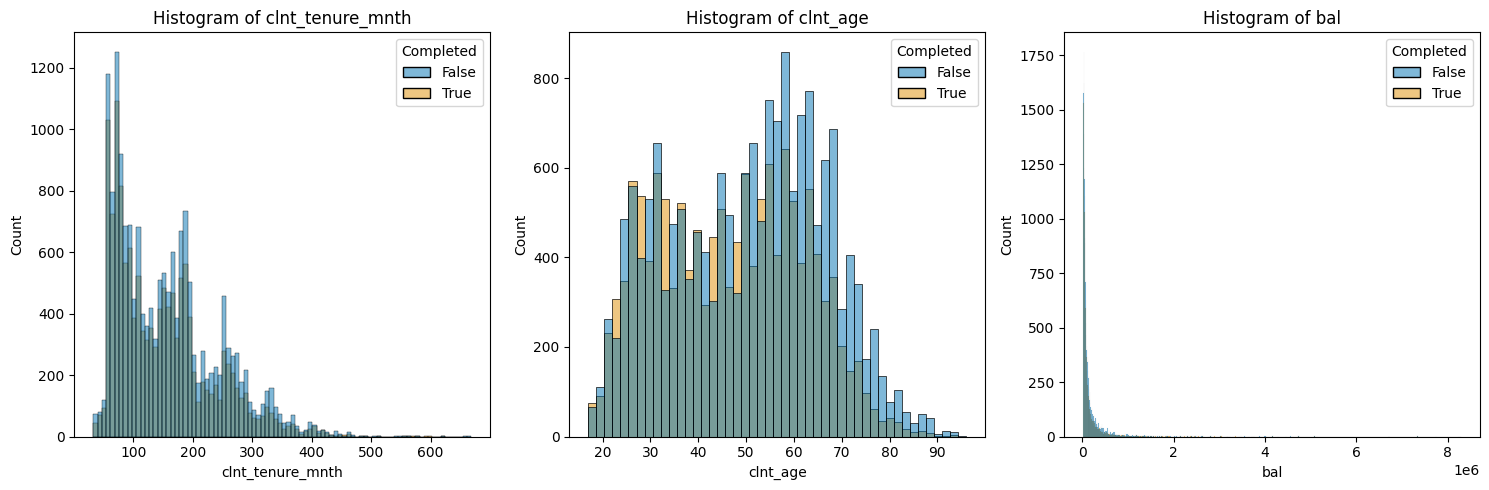

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'clnt_tenure_mnth'
sns.histplot(data=df_control, x='clnt_tenure_mnth', hue='Completed', palette='colorblind', ax=axes[0])
axes[0].set_title('Histogram of clnt_tenure_mnth')

# Plot for 'clnt_age'
sns.histplot(data=df_control, x='clnt_age', hue='Completed',  palette='colorblind', ax=axes[1])
axes[1].set_title('Histogram of clnt_age')

# Plot for 'bal'
sns.histplot(data=df_control, x='bal', hue='Completed',  palette='colorblind', ax=axes[2])
axes[2].set_title('Histogram of bal')

# Adjust the layout
plt.tight_layout()
plt.show()

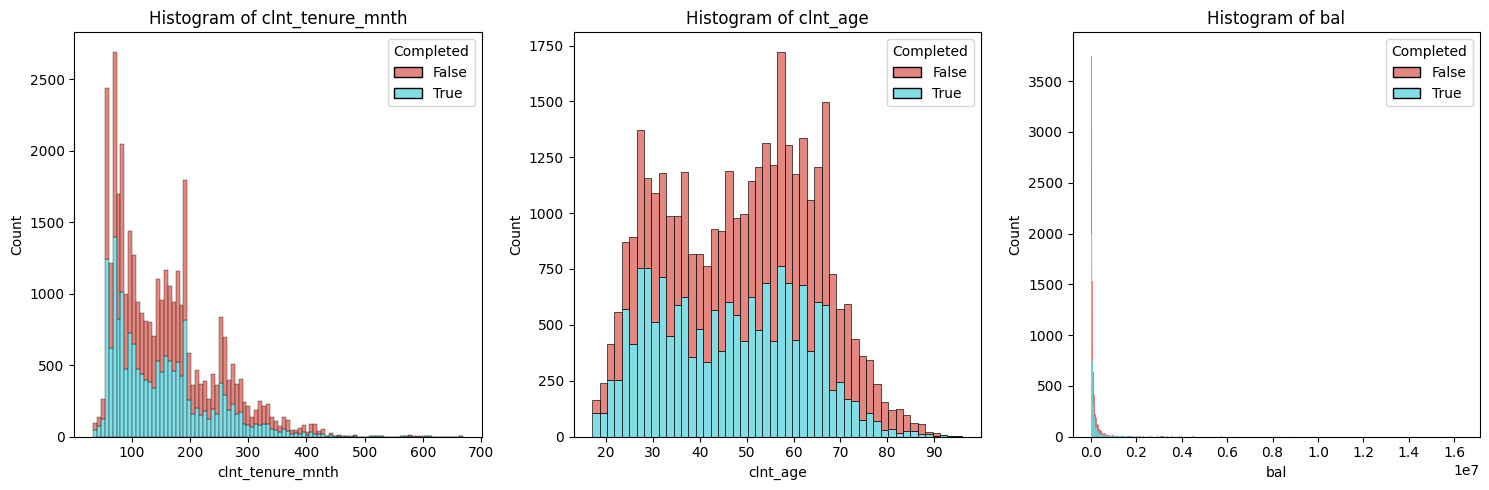

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'clnt_tenure_mnth'
sns.histplot(data=df_test, x='clnt_tenure_mnth', hue='Completed',multiple='stack', palette='hls', ax=axes[0])
axes[0].set_title('Histogram of clnt_tenure_mnth')

# Plot for 'clnt_age'
sns.histplot(data=df_test, x='clnt_age', hue='Completed', multiple='stack', palette='hls', ax=axes[1])
axes[1].set_title('Histogram of clnt_age')

# Plot for 'bal'
sns.histplot(data=df_test, x='bal', hue='Completed', multiple='stack', palette='hls', ax=axes[2])
axes[2].set_title('Histogram of bal')

# Adjust the layout
plt.tight_layout()
plt.savefig('../images/1_test_segmenationVScompletion_rate.png')
plt.show()

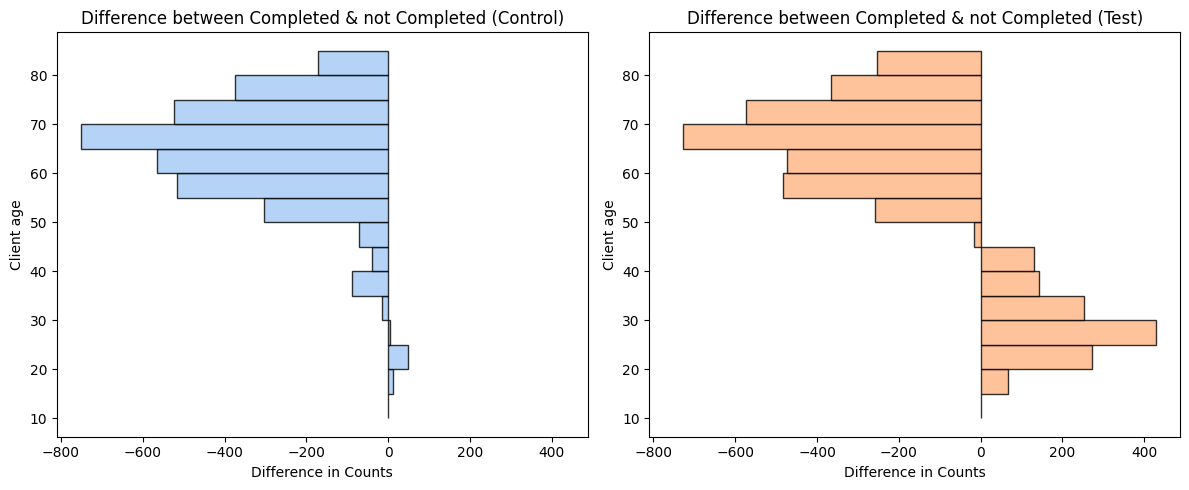

In [46]:
# Define bin edges
bin_edges = np.arange(10, 90, 5)

# Calculate histograms for each distribution
a_hist1, _ = np.histogram(df_control[df_control['Completed'] == True]['clnt_age'], bins=bin_edges)
b_hist1, _ = np.histogram(df_control[df_control['Completed'] == False]['clnt_age'], bins=bin_edges)

a_hist2, _ = np.histogram(df_test[df_test['Completed'] == True]['clnt_age'], bins=bin_edges)
b_hist2, _ = np.histogram(df_test[df_test['Completed'] == False]['clnt_age'], bins=bin_edges)

# Calculate bin midpoints
bin_midpoints = bin_edges[:-1] + np.diff(bin_edges) / 2

# Calculate the difference
h_diff1 = a_hist1 - b_hist1
h_diff2 = a_hist2 - b_hist2

# Plot the difference using seaborn
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Control Variation
axes[0].barh(y=bin_midpoints, width=h_diff1, color=sns.color_palette("pastel")[0], height=5, ec='k', alpha=0.8)
axes[0].set_ylabel('Client age')
axes[0].set_xlabel('Difference in Counts')
axes[0].set_title('Difference between Completed & not Completed (Control)')

# Plot for Test Variation
axes[1].barh(y=bin_midpoints, width=h_diff2, color=sns.color_palette("pastel")[1], height=5, ec='k', alpha=0.8)
axes[1].set_xlabel('Difference in Counts')
axes[1].set_ylabel('Client age')
axes[1].set_title('Difference between Completed & not Completed (Test)')

plt.tight_layout()
plt.savefig('../images/1_ageVScompletion_rate.png')
plt.show()

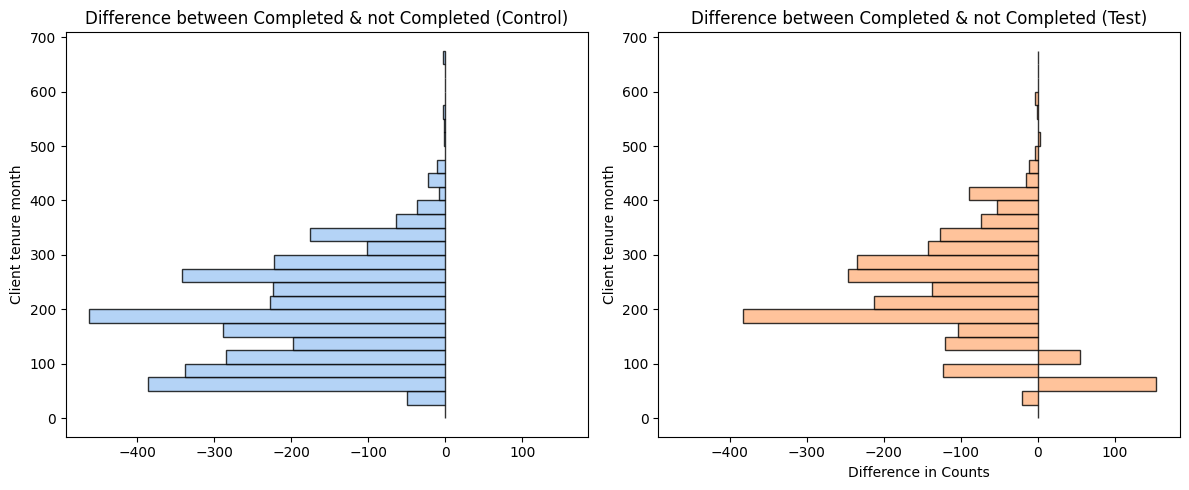

In [47]:
# Define bin edges
bin_edges = np.arange(0, 700, 25)

# Calculate histograms for each distribution
a_hist1, _ = np.histogram(df_control[df_control['Completed'] == True]['clnt_tenure_mnth'], bins=bin_edges)
b_hist1, _ = np.histogram(df_control[df_control['Completed'] == False]['clnt_tenure_mnth'], bins=bin_edges)

a_hist2, _ = np.histogram(df_test[df_test['Completed'] == True]['clnt_tenure_mnth'], bins=bin_edges)
b_hist2, _ = np.histogram(df_test[df_test['Completed'] == False]['clnt_tenure_mnth'], bins=bin_edges)

# Calculate bin midpoints
bin_midpoints = bin_edges[:-1] + np.diff(bin_edges) / 2

# Calculate the difference
h_diff1 = a_hist1 - b_hist1
h_diff2 = a_hist2 - b_hist2

# Plot the difference using seaborn
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Control Variation
axes[0].barh(y=bin_midpoints, width=h_diff1, height=25, color=sns.color_palette("pastel")[0], ec='k', alpha=0.8)
axes[0].set_ylabel('Client tenure month')
axes[0].set_title('Difference between Completed & not Completed (Control)')

# Plot for Test Variation
axes[1].barh(y=bin_midpoints, width=h_diff2, height=25, color=sns.color_palette("pastel")[1], ec='k', alpha=0.8)
axes[1].set_xlabel('Difference in Counts')
axes[1].set_ylabel('Client tenure month')
axes[1].set_title('Difference between Completed & not Completed (Test)')

plt.tight_layout()
plt.savefig('../images/1_tenureVScompletion_rate.png')
plt.show()

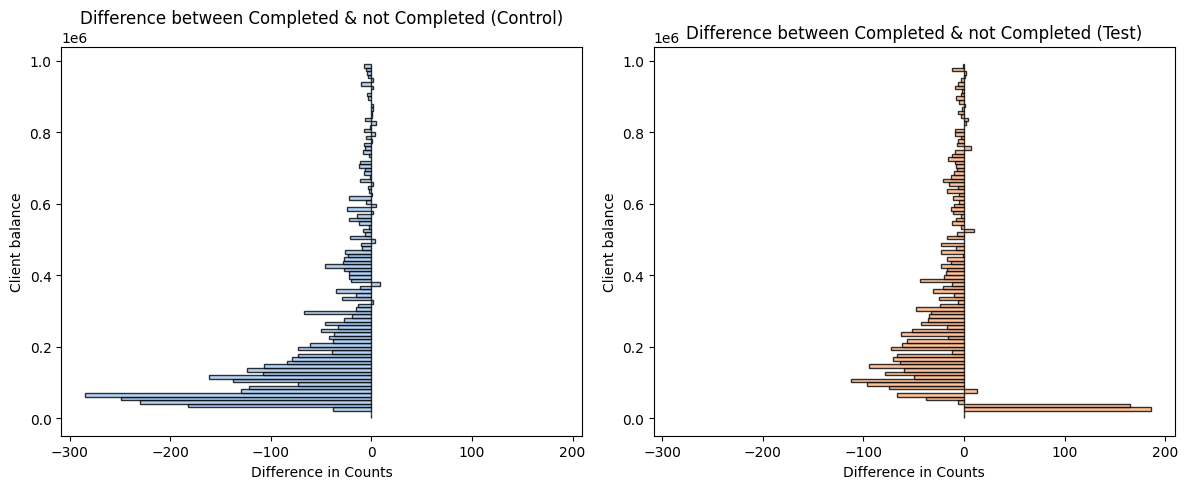

In [48]:
# Define bin edges
#bin_edges = np.arange(0, 40, 1)
bin_edges = np.arange(0, 1000000, 10000)
# Calculate histograms for each distribution
a_hist1, _ = np.histogram(df_control[df_control['Completed'] == True]['bal'], bins=bin_edges)
b_hist1, _ = np.histogram(df_control[df_control['Completed'] == False]['bal'], bins=bin_edges)

a_hist2, _ = np.histogram(df_test[df_test['Completed'] == True]['bal'], bins=bin_edges)
b_hist2, _ = np.histogram(df_test[df_test['Completed'] == False]['bal'], bins=bin_edges)

# Calculate bin midpoints
bin_midpoints = bin_edges[:-1] + np.diff(bin_edges) / 2

# Calculate the difference
h_diff1 = a_hist1 - b_hist1
h_diff2 = a_hist2 - b_hist2

# Plot the difference using seaborn
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Control Variation
axes[0].barh(y=bin_midpoints, width=h_diff1, height=10000, color=sns.color_palette("pastel")[0], ec='k', alpha=0.8)
axes[0].set_ylabel('Client balance')
axes[0].set_xlabel('Difference in Counts')
axes[0].set_title('Difference between Completed & not Completed (Control)')

# Plot for Test Variation
axes[1].barh(y=bin_midpoints, width=h_diff2, height=10000, color=sns.color_palette("pastel")[1], ec='k', alpha=0.8)
axes[1].set_xlabel('Difference in Counts')
axes[1].set_ylabel('Client balance')
axes[1].set_title('Difference between Completed & not Completed (Test)')

plt.tight_layout()
plt.savefig('../images/1_balanceVScompletion_rate.png')
plt.show()

In [49]:
# Create contingency tables for each variable with completion status
age_contingency = pd.crosstab(df_test['clnt_age'], df_test['Completed'])
tenure_contingency = pd.crosstab(df_test['clnt_tenure_mnth'], df_test['Completed'])
balance_contingency = pd.crosstab(df_test['bal'], df_test['Completed'])

In [50]:
from scipy.stats import chi2_contingency

# Perform Chi-square test
_, p_age, _, _ = chi2_contingency(age_contingency)
_, p_tenure, _, _ = chi2_contingency(tenure_contingency)
_, p_balance, _, _ = chi2_contingency(balance_contingency)

print("P-value for age group and completion status:", p_age)
print("P-value for tenure group and completion status:", p_tenure)
print("P-value for balance group and completion status:", p_balance)

P-value for age group and completion status: 0.0
P-value for tenure group and completion status: 9.1883867551236e-11
P-value for balance group and completion status: 0.22415633200952523


These p-values are very small, indicating highly significant relationships between completion status and the variables of age and tenure of clients using the new UI.

In [51]:
# Create contingency tables for each variable with completion status
age_contingency = pd.crosstab(df_control['clnt_age'], df_control['Completed'])
tenure_contingency = pd.crosstab(df_control['clnt_tenure_mnth'], df_control['Completed'])
balance_contingency = pd.crosstab(df_control['bal'], df_control['Completed'])

In [52]:

# Perform Chi-square test
_, p_age, _, _ = chi2_contingency(age_contingency)
_, p_tenure, _, _ = chi2_contingency(tenure_contingency)
_, p_balance, _, _ = chi2_contingency(balance_contingency)

print("P-value for age group and completion status:", p_age)
print("P-value for tenure group and completion status:", p_tenure)
print("P-value for balance group and completion status:", p_balance)

P-value for age group and completion status: 0.0
P-value for tenure group and completion status: 0.0003953934161719207
P-value for balance group and completion status: 0.004318299758031217


These findings suggest that while age and tenure have notable effects on completion rates for clients using the traditional UI, balance does not exhibit significant influence.

### Client Demographic & Completion Time

In [60]:
df_numerical = df_all.select_dtypes("number")

In [61]:
df_control = df_outliers[df_outliers['Variation'] == 'Control']
df_test = df_outliers[df_outliers['Variation'] == 'Test']

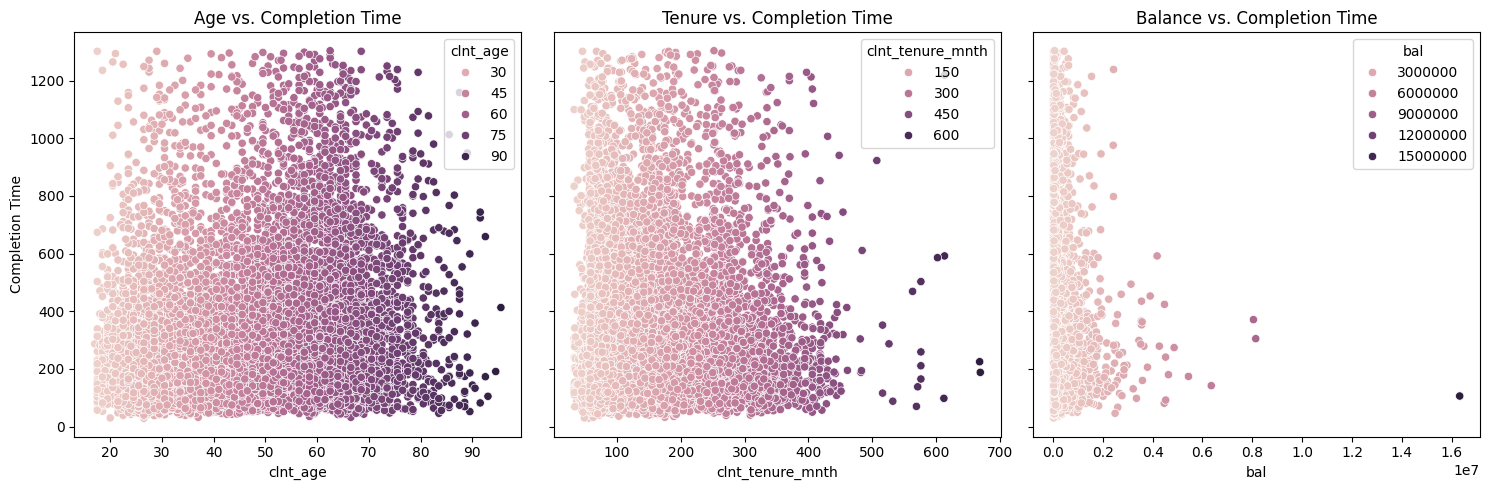

In [62]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15, 5))

# Scatterplot for age
sns.scatterplot(data=df_test, x='clnt_age', y='Completion Time', hue='clnt_age', ax=axes[0])
axes[0].set_title('Age vs. Completion Time')

# Scatterplot for tenure
sns.scatterplot(data=df_test, x='clnt_tenure_mnth', y='Completion Time', hue='clnt_tenure_mnth', ax=axes[1])
axes[1].set_title('Tenure vs. Completion Time')

# Scatterplot for balance
#df_test_f = df_test[df_test['bal'] <= 1000000]
sns.scatterplot(data=df_test, x='bal', y='Completion Time', hue='bal', ax=axes[2])
axes[2].set_title('Balance vs. Completion Time')

# Adjust layout
plt.tight_layout()
plt.savefig('../images/1_balanceVScompletion_rate.png')
# Show the plot
plt.show()

The F value in one way ANOVA is a tool to help you answer the question “Is the variance between the means of two populations significantly different?” 

In [93]:
from scipy.stats import f_oneway
# Categorize age into groups with sufficient range and non-empty bins
bins=[0, 20, 30, 40, 50, 60, 70, 100]
labels=['-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

df_test['age_group'] = pd.cut(df_test['clnt_age'], bins=bins, labels=labels, ordered=True)

# Check the distribution of data in each group
print("Distribution of age groups:")
print(df_test['age_group'].value_counts())

# Ensure there are enough data points in each group and variability within groups
age_groups = df_test['age_group'].dropna().unique()

# Prepare data for ANOVA by collecting Completion Time for each group
age_grouped_data = [df_test[df_test['age_group'] == group]['Completion Time'].dropna() for group in age_groups]

# Check variability within each group and filter out groups with insufficient variability or data
valid_age_grouped_data = [data for data in age_grouped_data if len(data) > 1 and data.var() > 0]

# Perform ANOVA if there is enough data and variability
try:
    if len(valid_age_grouped_data) > 1:
        f_statistic_age, p_value_anova_age = f_oneway(*valid_age_grouped_data)
        print(f"ANOVA F-statistic for age groups: {f_statistic_age}, P-value: {p_value_anova_age}")
    else:
        print("Not enough valid groups to perform ANOVA.")
except ValueError as e:
    print(f"Error performing ANOVA: {e}")

Distribution of age groups:
age_group
50-60    3620
30-40    3388
20-30    3046
40-50    3012
60-70    2883
70+       811
-20       210
Name: count, dtype: int64
ANOVA F-statistic for age groups: 131.92906385961066, P-value: 7.218312462542561e-164


C:\Users\salto\AppData\Local\Temp\ipykernel_4388\3946259861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['age_group'] = pd.cut(df_test['clnt_age'], bins=bins, labels=labels, ordered=True)


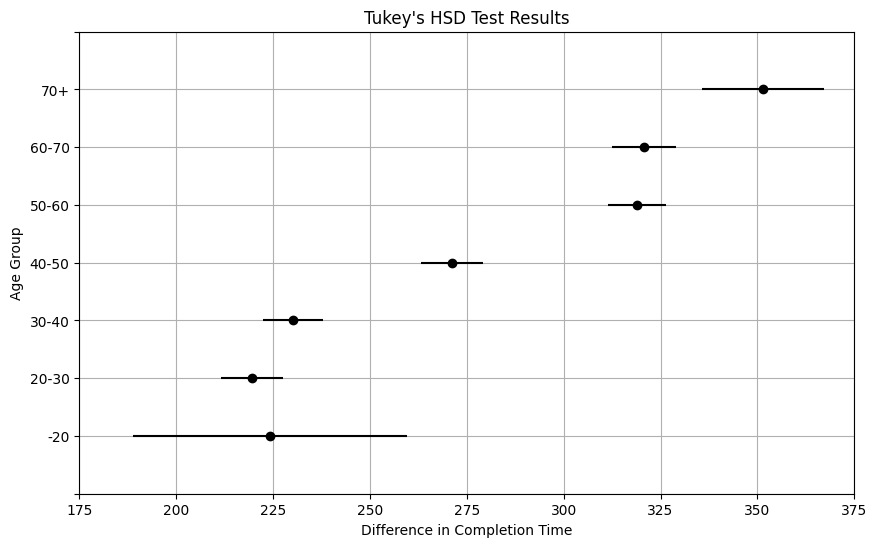

In [94]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#df_test.dropna(subset=['age_group'], inplace=True)

# Perform Tukey's HSD test
tukey_result1 = pairwise_tukeyhsd(endog=df_test['Completion Time'], groups=df_test['age_group'], alpha=0.05)
# Print the Tukey's HSD test results table
#print(tukey_result1.summary())

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
tukey_result1.plot_simultaneous(ylabel='Age Group', xlabel='Difference in Completion Time', ax=ax)
plt.xlim((175, 375))
plt.grid(True)
plt.title("Tukey's HSD Test Results")

plt.savefig('../images/1_age_groupsVScompletion_time.png')
# Ensure the y-axis categories are in the desired order
#ax.set_yticks(range(len(labels)))
#ax.set_yticklabels(labels)

plt.show()

Since the P-value is extremely low, we reject the null hypothesis that there are no differences between the means of completion times across different age groups. This implies that age has a significant effect on the completion time.

In [95]:
# Categorize tenure into groups with sufficient range and non-empty bins
bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 800]
labels=['-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450', '450+']

df_test['tenure_group'] = pd.cut(df_test['clnt_tenure_mnth'], bins=bins, labels=labels, ordered=True)

# Check the distribution of data in each group
print("Distribution of balance groups:")
print(df_test['tenure_group'].value_counts())

# Ensure there are enough data points in each group and variability within groups
tenure_groups = df_test['tenure_group'].dropna().unique()

# Prepare data for ANOVA by collecting Completion Time for each group
tenure_grouped_data = [df_test[df_test['tenure_group'] == group]['Completion Time'].dropna() for group in tenure_groups]

# Check variability within each group and filter out groups with insufficient variability or data
valid_tenure_grouped_data = [data for data in tenure_grouped_data if len(data) > 1 and data.var() > 0]

# Perform ANOVA if there is enough data and variability
try:
    if len(valid_tenure_grouped_data) > 1:
        f_statistic_tenure, p_value_anova_tenure = f_oneway(*valid_tenure_grouped_data)
        print(f"ANOVA F-statistic for tenure groups: {f_statistic_tenure}, P-value: {p_value_anova_tenure}")
    else:
        print("Not enough valid groups to perform ANOVA.")
except ValueError as e:
    print(f"Error performing ANOVA: {e}")

Distribution of balance groups:
tenure_group
-100       6382
150-200    3772
100-150    3229
250-300    1438
200-250    1281
300-350     520
350-400     214
400-450     107
450+         27
Name: count, dtype: int64
ANOVA F-statistic for tenure groups: 5.625607069560544, P-value: 3.755909402441234e-07


C:\Users\salto\AppData\Local\Temp\ipykernel_4388\2754375025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['tenure_group'] = pd.cut(df_test['clnt_tenure_mnth'], bins=bins, labels=labels, ordered=True)


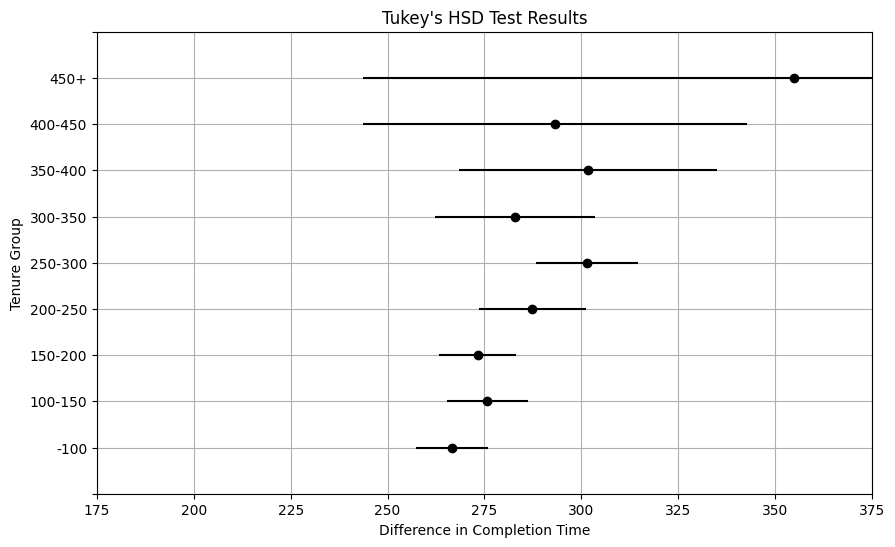

In [97]:
# Perform Tukey's HSD test
tukey_result1 = pairwise_tukeyhsd(endog=df_test['Completion Time'], groups=df_test['tenure_group'], alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
tukey_result1.plot_simultaneous(ylabel='Tenure Group', xlabel='Difference in Completion Time', ax=ax)
plt.xlim((175, 375))
plt.grid(True)
plt.title("Tukey's HSD Test Results")
plt.savefig('../images/1_tenure_groupsVScompletion_time.png')
# Ensure the y-axis categories are in the desired order
#ax.set_yticks(range(len(labels)))
#ax.set_yticklabels(labels)

plt.show()

Since the P-value is extremely low, we reject the null hypothesis that there are no differences between the means of completion times across different tenure groups. This implies that tenure has a significant effect on the completion time. However, from the Tuckeys HSD test it seems that there not significant differences within the confidence level between the groups of different tenure.

In [103]:
# Categorize balance into groups with sufficient range and non-empty bins
bins=[0, 50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000,  df_test['bal'].max()]
labels=['-50K','050-100K', '100-200K', '200-300K', '300-400K', '400-500K', '500-600K', '600-700K', '700-800K', '800-900K', '900K+']

df_test['balance_group'] = pd.cut(df_test['bal'], bins=bins, labels=labels, ordered=True)

# Check the distribution of data in each group
print("Distribution of balance groups:")
print(df_test['balance_group'].value_counts())

# Ensure there are enough data points in each group and variability within groups
balance_groups = df_test['balance_group'].dropna().unique()

# Prepare data for ANOVA by collecting Completion Time for each group
balance_grouped_data = [df_test[df_test['balance_group'] == group]['Completion Time'].dropna() for group in balance_groups]

# Check variability within each group and filter out groups with insufficient variability or data
valid_balance_grouped_data = [data for data in balance_grouped_data if len(data) > 1 and data.var() > 0]

# Perform ANOVA if there is enough data and variability
try:
    if len(valid_balance_grouped_data) > 1:
        f_statistic_balance, p_value_anova_balance = f_oneway(*valid_balance_grouped_data)
        print(f"ANOVA F-statistic for balance groups: {f_statistic_balance}, P-value: {p_value_anova_balance}")
    else:
        print("Not enough valid groups to perform ANOVA.")
except ValueError as e:
    print(f"Error performing ANOVA: {e}")

Distribution of balance groups:
balance_group
-50K        6350
050-100K    4812
100-200K    2902
200-300K    1082
300-400K     548
400-500K     355
900K+        332
500-600K     234
600-700K     159
700-800K     116
800-900K      80
Name: count, dtype: int64
ANOVA F-statistic for balance groups: 9.869013256140464, P-value: 1.1244051111309503e-16


C:\Users\salto\AppData\Local\Temp\ipykernel_4388\3558169375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['balance_group'] = pd.cut(df_test['bal'], bins=bins, labels=labels, ordered=True)


C:\Users\salto\Documents\DataAnalytics\Module2-Project\m2_venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


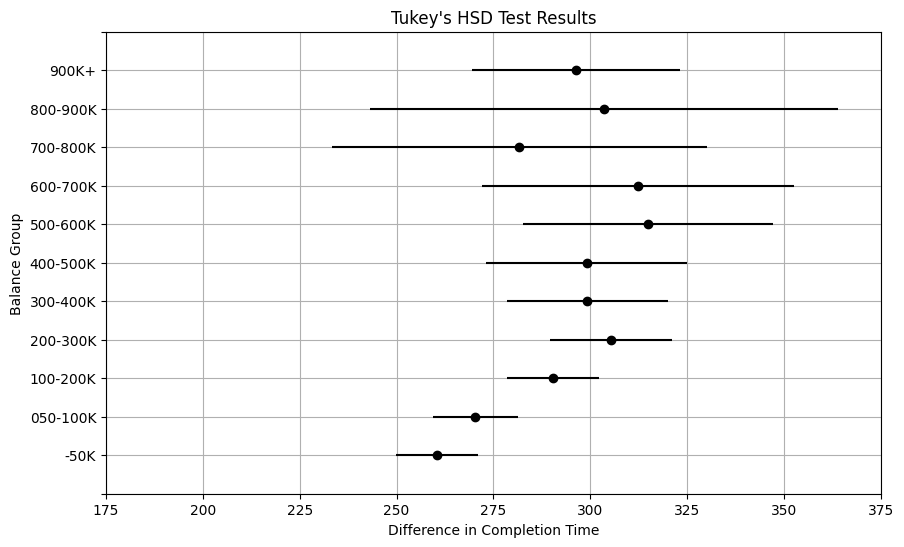

In [104]:
# Perform Tukey's HSD test
tukey_result1 = pairwise_tukeyhsd(endog=df_test['Completion Time'], groups=df_test['balance_group'], alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
tukey_result1.plot_simultaneous(ylabel='Balance Group', xlabel='Difference in Completion Time', ax=ax)
plt.xlim((175, 375))
plt.grid(True)
plt.title("Tukey's HSD Test Results")
plt.savefig('../images/1_balance_groupsVScompletion_time.png')
# Ensure the y-axis categories are in the desired order
#ax.set_yticks(range(len(labels)))
#ax.set_yticklabels(labels)

plt.show()

* F-statistic: This value indicates a notable difference in the variance of completion times between the balance groups.
* P-value: A very small P-value (much less than 0.05) suggests that the differences in completion times between the balance groups are statistically significant.

Since the P-value is extremely low, we reject the null hypothesis that there are no differences between the means of completion times across different balance groups. This implies that the balance amount has a significant effect on the completion time. However, from the Tuckeys HSD test it seems that there not significant differences within the confidence level between the groups of different tenure.

### Client Demographics & Error Rate

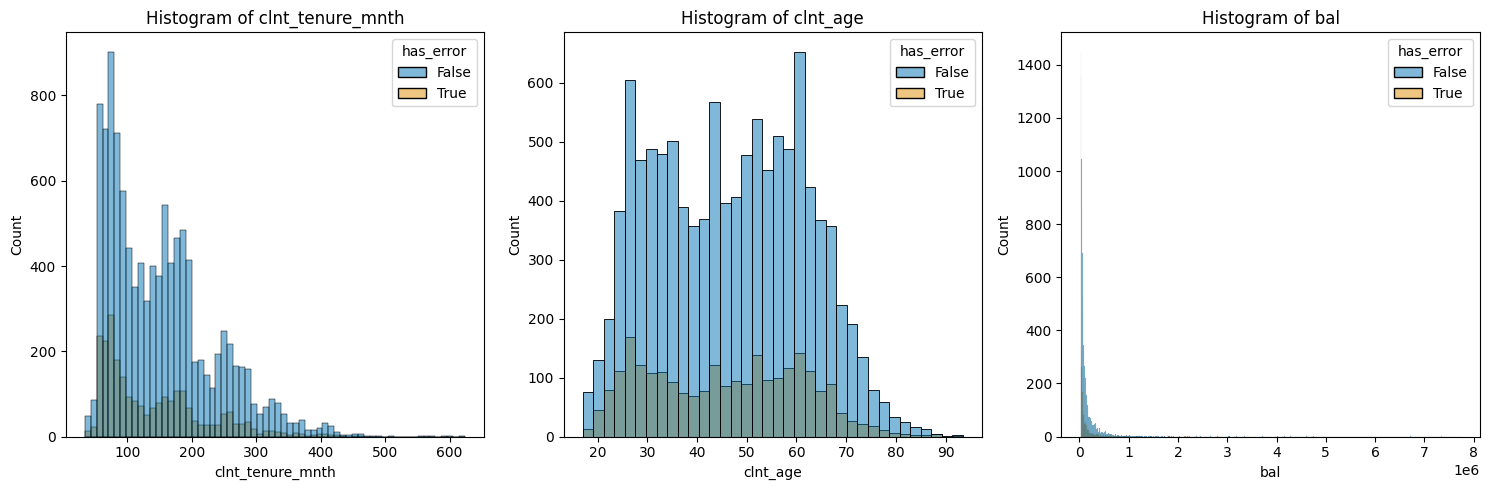

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'clnt_tenure_mnth'
sns.histplot(data=df_control, x='clnt_tenure_mnth', hue='has_error', palette='colorblind', ax=axes[0])
axes[0].set_title('Histogram of clnt_tenure_mnth')

# Plot for 'clnt_age'
sns.histplot(data=df_control, x='clnt_age', hue='has_error',  palette='colorblind', ax=axes[1])
axes[1].set_title('Histogram of clnt_age')

# Plot for 'bal'
sns.histplot(data=df_control, x='bal', hue='has_error',  palette='colorblind', ax=axes[2])
axes[2].set_title('Histogram of bal')

# Adjust the layout
plt.tight_layout()
plt.show()

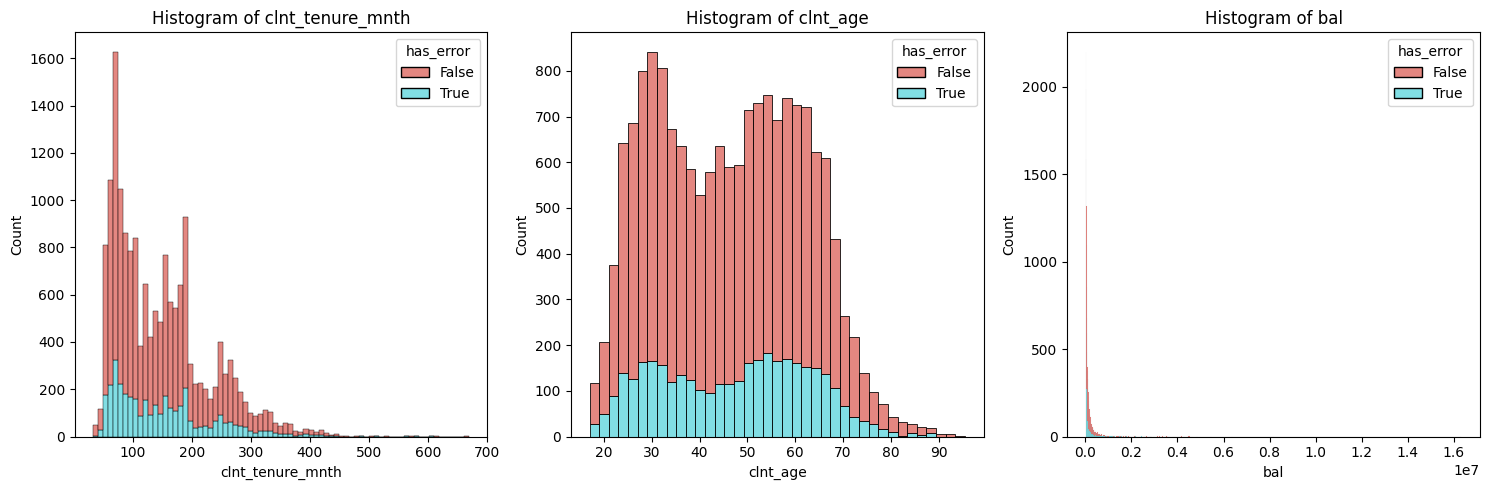

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'clnt_tenure_mnth'
sns.histplot(data=df_test, x='clnt_tenure_mnth', hue='has_error',multiple='stack', palette='hls', ax=axes[0])
axes[0].set_title('Histogram of clnt_tenure_mnth')

# Plot for 'clnt_age'
sns.histplot(data=df_test, x='clnt_age', hue='has_error', multiple='stack', palette='hls', ax=axes[1])
axes[1].set_title('Histogram of clnt_age')

# Plot for 'bal'
sns.histplot(data=df_test, x='bal', hue='has_error', multiple='stack', palette='hls', ax=axes[2])
axes[2].set_title('Histogram of bal')

# Adjust the layout
plt.tight_layout()
plt.savefig('../images/1_test_segmenationVSerror_rate.png')
plt.show()

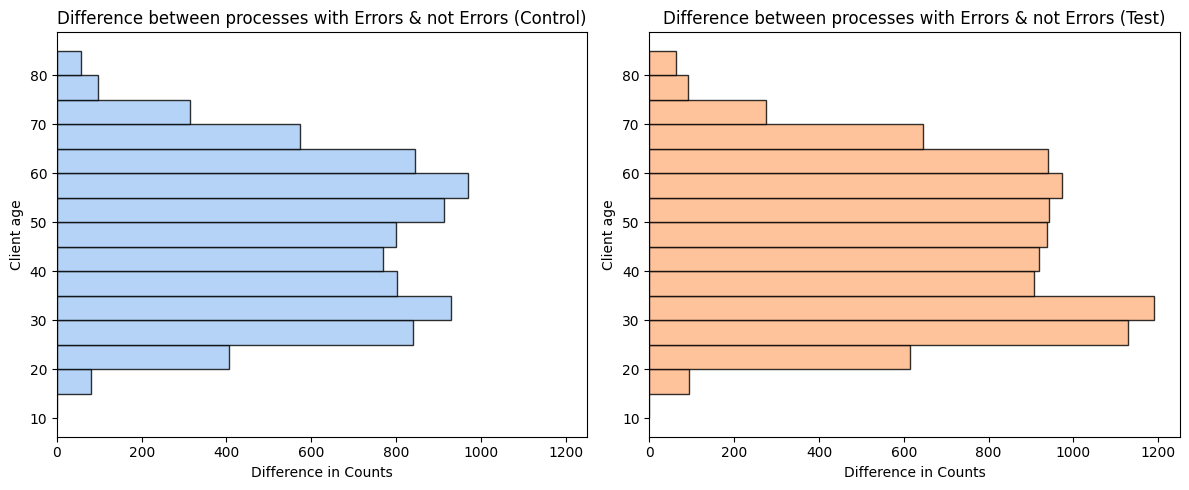

In [64]:
# Define bin edges
bin_edges = np.arange(10, 90, 5)

# Calculate histograms for each distribution
a_hist1, _ = np.histogram(df_control[df_control['has_error'] == False]['clnt_age'], bins=bin_edges)
b_hist1, _ = np.histogram(df_control[df_control['has_error'] == True]['clnt_age'], bins=bin_edges)

a_hist2, _ = np.histogram(df_test[df_test['has_error'] == False]['clnt_age'], bins=bin_edges)
b_hist2, _ = np.histogram(df_test[df_test['has_error'] == True]['clnt_age'], bins=bin_edges)

# Calculate bin midpoints
bin_midpoints = bin_edges[:-1] + np.diff(bin_edges) / 2

# Calculate the difference
h_diff1 = a_hist1 - b_hist1
h_diff2 = a_hist2 - b_hist2

# Plot the difference using seaborn
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Control Variation
axes[0].barh(y=bin_midpoints, width=h_diff1, color=sns.color_palette("pastel")[0], height=5, ec='k', alpha=0.8)
axes[0].set_ylabel('Client age')
axes[0].set_xlabel('Difference in Counts')
axes[0].set_title('Difference between processes with Errors & not Errors (Control)')

# Plot for Test Variation
axes[1].barh(y=bin_midpoints, width=h_diff2, color=sns.color_palette("pastel")[1], height=5, ec='k', alpha=0.8)
axes[1].set_xlabel('Difference in Counts')
axes[1].set_ylabel('Client age')
axes[1].set_title('Difference between processes with Errors & not Errors (Test)')

plt.tight_layout()
plt.savefig('../images/1_ageVScompletion_rate.png')
plt.show()

In [65]:
# Create contingency tables for each variable with completion status
age_contingency = pd.crosstab(df_test['clnt_age'], df_test['has_error'])
tenure_contingency = pd.crosstab(df_test['clnt_tenure_mnth'], df_test['has_error'])
balance_contingency = pd.crosstab(df_test['bal'], df_test['has_error'])

In [66]:
from scipy.stats import chi2_contingency

# Perform Chi-square test
_, p_age, _, _ = chi2_contingency(age_contingency)
_, p_tenure, _, _ = chi2_contingency(tenure_contingency)
_, p_balance, _, _ = chi2_contingency(balance_contingency)

print("P-value for age group and error status in the control group:", p_age)
print("P-value for tenure group and error status in the control group:", p_tenure)
print("P-value for balance group and error status in the control group:", p_balance)

P-value for age group and error status in the control group: 0.01643905607495465
P-value for tenure group and error status in the control group: 0.055464633126804136
P-value for balance group and error status in the control group: 0.4828616480864621


These p-value slightly below 5 % indicates potential relationship between error status and the age of clients using the new UI.

In [67]:
# Create contingency tables for each variable with completion status
age_contingency = pd.crosstab(df_control['clnt_age'], df_control['has_error'])
tenure_contingency = pd.crosstab(df_control['clnt_tenure_mnth'], df_control['has_error'])
balance_contingency = pd.crosstab(df_control['bal'], df_control['has_error'])

In [68]:

# Perform Chi-square test
_, p_age, _, _ = chi2_contingency(age_contingency)
_, p_tenure, _, _ = chi2_contingency(tenure_contingency)
_, p_balance, _, _ = chi2_contingency(balance_contingency)

print("P-value for age group and error status in the test group:", p_age)
print("P-value for tenure group and error status in the test group:", p_tenure)
print("P-value for balance group and error status in the test group:", p_balance)

P-value for age group and error status in the test group: 0.0027083769717716677
P-value for tenure group and error status in the test group: 0.2583444778049256
P-value for balance group and error status in the test group: 0.4902212366201325


# Data-driven recommendations

Insights and recommendations regarding the new user interface (UI) and its impact on user behavior.

1. KPI: Completion Rates
Finding: The completion rate for the test group (47.42%) is higher than the control group (44.49%). This difference is statistically significant (P-Value: 2.41e-14).
Recommendation: Adopt the New UI: The new UI has a higher completion rate, indicating that it effectively encourages users to complete the process. Implementing the new UI can improve overall user engagement and process completion.

2. KPI: Completion Times
Finding: The average completion time for the test group (275.59 seconds) is significantly lower than the control group (285.93 seconds) (P-Value: 3.50e-06). This suggests that the new UI helps users complete the process faster.
Step-wise Analysis:
Step 1: Significant reduction in completion time (P-Value: 3.13e-08).
Step 2: Significant reduction in completion time (P-Value: 1.26e-12).
Step 3: Slightly longer time but still significant (P-Value: 0.0205).
Confirm Step: No significant difference (P-Value: 0.1238).
Recommendation: Optimize Steps: While the new UI reduces overall completion time, steps should be monitored to ensure consistent performance improvements. Continue refining Steps 3 and Confirmation to further streamline the process.


3. KPI: Error Rates
Finding: The error rate for the test group (9.85%) is higher than the control group (7.88%), and this difference is statistically significant (P-Value: 3.87e-19).
Recommendation: Address Error-Prone Areas: Investigate the higher error rates in the new UI. Conduct user testing to identify specific pain points and make necessary adjustments to reduce errors.


4. Segmentation Analysis for the new UI
* Completion Status:
Age: Highly significant difference (P-Value: 0.0).
Tenure: Significant difference (P-Value: 9.19e-11).
Balance: No significant difference (P-Value: 0.2242).

* Completion Times:
Age: Highly significant difference (ANOVA P-Value: 7.22e-164).
Tenure: Significant difference (ANOVA P-Value: 1.10e-07).
Balance: Significant difference (ANOVA P-Value: 4.57e-18).

* Error Status:
Age: Significant difference (P-Value: 0.0164).
Tenure: Marginally significant difference (P-Value: 0.0555).
Balance: No significant difference (P-Value: 0.4829).


Recommendation: Tailor the UI to User Segments: The new UI impacts different user segments (age, tenure, balance) differently. Consider personalizing the UI experience based on these segments to enhance usability and completion rates for all users.

5. General Recommendations
User Feedback Integration: Continuously collect and integrate user feedback to identify and fix issues rapidly.
Iterative Improvements: Implement an iterative approach to UI enhancements, regularly testing and refining elements to optimize user experience.
Comprehensive Training: Provide users with training or tutorials on the new UI to minimize the learning curve and reduce error rates.
Monitoring and Analysis: Continuously monitor key performance indicators (KPIs) such as completion rates, error rates, and user satisfaction to ensure ongoing improvement.

7. Conclusion
The new UI has shown promising results in increasing completion rates and reducing completion times, although it has also led to higher error rates. By addressing the specific areas where users encounter difficulties and tailoring the experience based on user segments, Vanguard can further enhance its online client experience and achieve better engagement and satisfaction.